In [59]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [2]:
%matplotlib inline
from typing import List, Tuple, Dict, Callable
Query = Tuple[str, str]
Location = Tuple[float, float, float]  # start(sec.), end(sec.), length(sec.)
Instance = Tuple[Query, Location]
Rating = List[float]
Prediction = Tuple[Query, List[Location], Rating]
Result = Tuple[Query, List[Location], Rating, dict]

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class, predict
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class
from src.toolbox.data_converters import ActivityNetCap2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns
sns.set()
import json
import pickle as pkl

In [4]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [5]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

pkl.dump(results,
    open("reports/figure_src/results/activitynet/2d-tan.pkl", "wb"))

R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62


In [20]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/shuffle/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
shuffle_results = evaluate(test_data, preds)
shuffle_summary = accumulate_metrics(shuffle_results)

R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.62


In [44]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/2D-TAN/results/random/ActivityNet/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
random_results = evaluate(test_data, preds)
random_summary = accumulate_metrics(random_results)

R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.75
R@5 IoU>0.7 0.60
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.75
R@10 IoU>0.7 0.60


(0, 1)

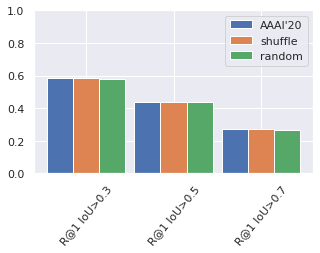

In [53]:
plt.figure(figsize=(5, 3))
plt.bar(np.arange(3)+0.2, list(summary.values())[:3], width=0.3, label="AAAI'20")
plt.bar(np.arange(3)+0.5, list(shuffle_summary.values())[:3], width=0.3, label="shuffle")
plt.bar(np.arange(3)+0.8, list(random_summary.values())[:3], width=0.3, label="random")
plt.xticks(ticks=np.arange(3)+0.5, labels=list(summary.keys())[:3], rotation=50)
plt.legend()
plt.ylim(0, 1)

In [62]:
pkl.dump(results,
        open("reports/figure_src/results/activitynet/2d-tan.pkl", "wb"))

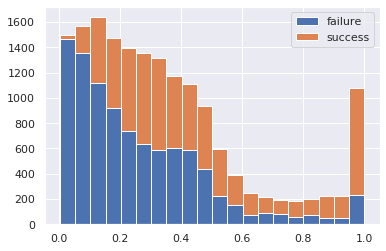

In [63]:
failure = []
success = []
for r, gt_dat in zip(results, test_data):
    _, (s, e, l) = gt_dat
    duration = (e - s) / l
    is_succeed = r[-1]['R@1 IoU>0.5']
    if is_succeed:
        success.append(duration)
    else:
        failure.append(duration)

plt.hist([failure, success], bins=20, stacked=True, label=["failure", "success"])
plt.legend()
# _, axes = plt.subplots(2, 1, sharex=True, sharey=True)
# axes[0].hist(success, bins=20)
# axes[0].set_title("success")
# axes[1].hist(failure, bins=20)
# axes[1].set_title("failure")